## 3.1 Data Loading and Preprocessing

In [ ]:
import os
import zipfile
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np





def unzip_data(zip_path, extract_to):
    """Unzip the dataset if it exists."""
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

zip_file_path = "double_mnist.zip"
extracted_folder = "double_mnist"
unzip_data(zip_file_path, extracted_folder)





transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

def one_hot_encode_label(label_vector, num_classes=11):

    one_hot_matrix = np.zeros((3, num_classes), dtype=np.float32)

    for i in range(3):
        if label_vector[i] == 10:
            
            one_hot_matrix[i, -1] = 1
        else:
            one_hot_matrix[i, label_vector[i]] = 1

    return one_hot_matrix

def load_mnist_data_multilabel(data_dir):
    train_data, train_labels = [], []
    val_data, val_labels = [], []
    test_data, test_labels = [], []

    for split in ["train", "val", "test"]:
        split_path = os.path.join(data_dir, split)

        for label_folder in os.listdir(split_path):
            label_path = os.path.join(split_path, label_folder)

            
            if label_folder == '0':
               
                label_vector = [10, 10, 10]
            else:
                label_vector = [10, 10, 10] 
                for i in range(len(label_folder)):
                    label_vector[i] = int(label_folder[i]) 

            one_hot_matrix = one_hot_encode_label(label_vector)

            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = Image.open(img_path)
                img_tensor = transform(img)

                if split == "train":
                    train_data.append(img_tensor)
                    train_labels.append(label_vector)
                elif split == "val":
                    val_data.append(img_tensor)
                    val_labels.append(label_vector)
                elif split == "test":
                    test_data.append(img_tensor)
                    test_labels.append(label_vector)

    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

class MultiLabelMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long) 
        return image, label

data_dir = "double_mnist/double_mnist" 
train_data, val_data, test_data = load_mnist_data_multilabel(data_dir)

train_loader = DataLoader(MultiLabelMNISTDataset(*train_data), batch_size=32, shuffle=True)
val_loader = DataLoader(MultiLabelMNISTDataset(*val_data), batch_size=32, shuffle=False)
test_loader = DataLoader(MultiLabelMNISTDataset(*test_data), batch_size=32, shuffle=False)




## 3.2 Implement the MultiLabelCNN Class

In [ ]:
class MultiLabelCNN(nn.Module):
    def __init__(self, num_classes=11, num_digits=3, dropout=0):
        super(MultiLabelCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128 * 3 * 3, 128)

        self.fc2 = nn.Linear(128, num_digits * num_classes)

        self.num_digits = num_digits
        self.num_classes = num_classes

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        x = x.view(-1, self.num_digits, self.num_classes)

        return x

Yes, an additional activation layer is required. This layer is required to convert the output that we get in terms of elements of a 3x11 matrix to 3 values which are actually the outputs. So we can say the 33 nodes to be converted to 3 nodes using the activation function.

This is probably done using the max function being used for converting one hot array to value.

-----------------------------------------------


## 3.3 Hyperparameter Tuning


Training with lr=0.001 and dropout_rate=0
Epoch [1/25], Train Loss: 1.6508, Val Loss: 1.7699
Exact Match Accuracy: 0.0449, Hamming Accuracy: 0.4055
Epoch [2/25], Train Loss: 1.3834, Val Loss: 1.6598
Exact Match Accuracy: 0.0608, Hamming Accuracy: 0.4591
Epoch [3/25], Train Loss: 1.2379, Val Loss: 1.6521
Exact Match Accuracy: 0.0469, Hamming Accuracy: 0.4569
Epoch [4/25], Train Loss: 1.1363, Val Loss: 1.7052
Exact Match Accuracy: 0.0555, Hamming Accuracy: 0.4767
Epoch [5/25], Train Loss: 1.0706, Val Loss: 1.4597
Exact Match Accuracy: 0.0492, Hamming Accuracy: 0.4780
Epoch [6/25], Train Loss: 1.0229, Val Loss: 1.5156
Exact Match Accuracy: 0.0585, Hamming Accuracy: 0.5124
Epoch [7/25], Train Loss: 0.9774, Val Loss: 1.5526
Exact Match Accuracy: 0.0618, Hamming Accuracy: 0.5070
Epoch [8/25], Train Loss: 0.9200, Val Loss: 1.5502
Exact Match Accuracy: 0.0632, Hamming Accuracy: 0.5219
Epoch [9/25], Train Loss: 0.8457, Val Loss: 1.3748
Exact Match Accuracy: 0.0822, Hamming Accuracy: 0.5623
Epo

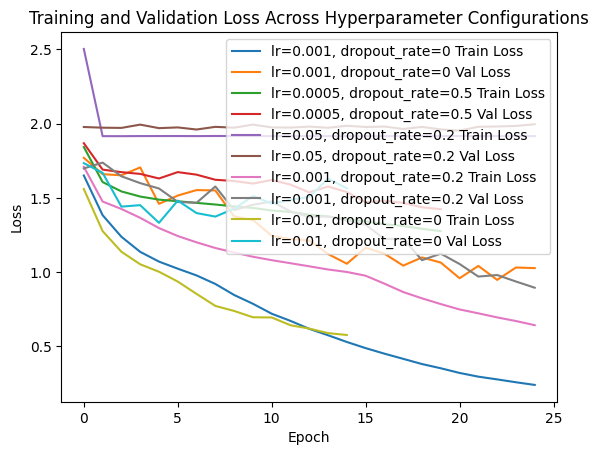

Hyperparams lr=0.001, dropout_rate=0: Exact Match Accuracy = 0.3913, Hamming Accuracy = 0.7723
Hyperparams lr=0.0005, dropout_rate=0.5: Exact Match Accuracy = 0.0392, Hamming Accuracy = 0.4492
Hyperparams lr=0.05, dropout_rate=0.2: Exact Match Accuracy = 0.0000, Hamming Accuracy = 0.3441
Hyperparams lr=0.001, dropout_rate=0.2: Exact Match Accuracy = 0.2859, Hamming Accuracy = 0.7156
Hyperparams lr=0.01, dropout_rate=0: Exact Match Accuracy = 0.1978, Hamming Accuracy = 0.6613


In [ ]:

def train_multi_label_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)


            loss = sum([criterion(outputs[:, i, :], labels[:, i]) for i in range(model.num_digits)]) / model.num_digits
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss, exact_match_acc, hamming_acc = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)

                loss = sum([criterion(outputs[:, i, :], labels[:, i]) for i in range(model.num_digits)]) / model.num_digits
                val_loss += loss.item()

                _, predictions = torch.max(outputs, dim=2)

                exact_match_acc += (predictions == labels).all(dim=1).float().mean().item()

                hamming_acc += (predictions == labels).float().mean().item()

        avg_val_loss = val_loss / len(val_loader)
        exact_match_acc /= len(val_loader)
        hamming_acc /= len(val_loader)

        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Exact Match Accuracy: {exact_match_acc:.4f}, Hamming Accuracy: {hamming_acc:.4f}")

    return train_losses, val_losses, exact_match_acc, hamming_acc

hyperparams = [
    {'lr': 0.001, 'dropout_rate': 0, 'epochs': 25},
   {'lr': 0.0005, 'dropout_rate': 0.5, 'epochs': 20},
    {'lr': 0.05, 'dropout_rate': 0.2, 'epochs': 25},
    {'lr': 0.001, 'dropout_rate': 0.2, 'epochs': 25},
    {'lr': 0.01, 'dropout_rate': 0, 'epochs': 15},
]


results = {}


for hp in hyperparams:
    print(f"\nTraining with lr={hp['lr']} and dropout_rate={hp['dropout_rate']}")

    model = MultiLabelCNN(num_classes=11, num_digits=3, dropout=hp['dropout_rate'])

    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(model.parameters(), lr=hp['lr'])

    train_losses, val_losses, exact_match_acc, hamming_acc = train_multi_label_model(
        model, train_loader, val_loader, criterion, optimizer,epochs=hp['epochs']
    )

    results[f"lr={hp['lr']}, dropout_rate={hp['dropout_rate']}"] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'exact_match_acc': exact_match_acc,
        'hamming_acc': hamming_acc
    }

for hp, metrics in results.items():
    plt.plot(metrics['train_losses'], label=f"{hp} Train Loss")
    plt.plot(metrics['val_losses'], label=f"{hp} Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Across Hyperparameter Configurations")
plt.show()

for hp, metrics in results.items():
    print(f"Hyperparams {hp}: Exact Match Accuracy = {metrics['exact_match_acc']:.4f}, Hamming Accuracy = {metrics['hamming_acc']:.4f}")

Best Model : 'lr': 0.001, 'dropout_rate': 0, 'epochs': 25
Considering epochs to be 30.


Training with lr=0.001 and dropout_rate=0
Epoch [1/30], Train Loss: 1.6375, Val Loss: 1.6771
Exact Match Accuracy: 0.0386, Hamming Accuracy: 0.4219
Epoch [2/30], Train Loss: 1.4025, Val Loss: 1.5983
Exact Match Accuracy: 0.0369, Hamming Accuracy: 0.4304
Epoch [3/30], Train Loss: 1.2492, Val Loss: 1.5332
Exact Match Accuracy: 0.0469, Hamming Accuracy: 0.4723
Epoch [4/30], Train Loss: 1.1482, Val Loss: 1.5176
Exact Match Accuracy: 0.0552, Hamming Accuracy: 0.4889
Epoch [5/30], Train Loss: 1.0700, Val Loss: 1.6183
Exact Match Accuracy: 0.0453, Hamming Accuracy: 0.4941
Epoch [6/30], Train Loss: 1.0204, Val Loss: 1.5568
Exact Match Accuracy: 0.0509, Hamming Accuracy: 0.4997
Epoch [7/30], Train Loss: 0.9741, Val Loss: 1.4583
Exact Match Accuracy: 0.0786, Hamming Accuracy: 0.5168
Epoch [8/30], Train Loss: 0.9277, Val Loss: 1.5975
Exact Match Accuracy: 0.0658, Hamming Accuracy: 0.5168
Epoch [9/30], Train Loss: 0.8670, Val Loss: 1.3932
Exact Match Accuracy: 0.0844, Hamming Accuracy: 0.5535
Epo

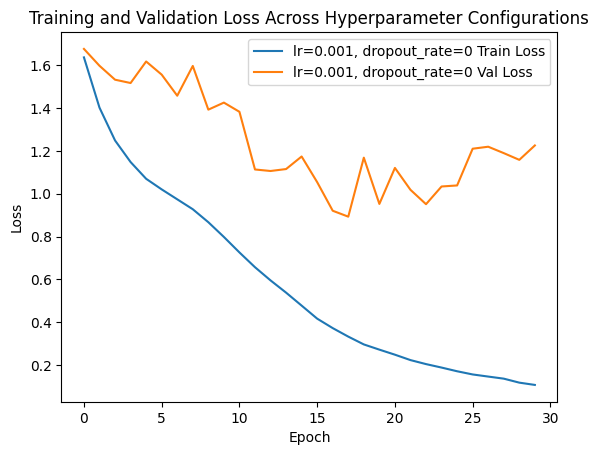

Hyperparams lr=0.001, dropout_rate=0: Exact Match Accuracy = 0.4187, Hamming Accuracy = 0.7848


In [ ]:

def train_multi_label_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)

            loss = sum([criterion(outputs[:, i, :], labels[:, i]) for i in range(model.num_digits)]) / model.num_digits
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss, exact_match_acc, hamming_acc = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)

        
                loss = sum([criterion(outputs[:, i, :], labels[:, i]) for i in range(model.num_digits)]) / model.num_digits
                val_loss += loss.item()

                _, predictions = torch.max(outputs, dim=2)

                exact_match_acc += (predictions == labels).all(dim=1).float().mean().item()

                hamming_acc += (predictions == labels).float().mean().item()

        avg_val_loss = val_loss / len(val_loader)
        exact_match_acc /= len(val_loader)
        hamming_acc /= len(val_loader)

        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Exact Match Accuracy: {exact_match_acc:.4f}, Hamming Accuracy: {hamming_acc:.4f}")

    return train_losses, val_losses, exact_match_acc, hamming_acc


hyperparams = [
    {'lr': 0.001, 'dropout_rate': 0, 'epochs': 30},
]


results = {}


for hp in hyperparams:
    print(f"\nTraining with lr={hp['lr']} and dropout_rate={hp['dropout_rate']}")

    model = MultiLabelCNN(num_classes=11, num_digits=3, dropout=hp['dropout_rate'])

    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=hp['lr'])

   
    train_losses, val_losses, exact_match_acc, hamming_acc = train_multi_label_model(
        model, train_loader, val_loader, criterion, optimizer,epochs=hp['epochs']
    )

    results[f"lr={hp['lr']}, dropout_rate={hp['dropout_rate']}"] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'exact_match_acc': exact_match_acc,
        'hamming_acc': hamming_acc
    }

# Plot training and validation losses for each hyperparameter configuration
for hp, metrics in results.items():
    plt.plot(metrics['train_losses'], label=f"{hp} Train Loss")
    plt.plot(metrics['val_losses'], label=f"{hp} Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Across Hyperparameter Configurations")
plt.show()

# Display Exact Match and Hamming Accuracy for each configuration
for hp, metrics in results.items():
    print(f"Hyperparams {hp}: Exact Match Accuracy = {metrics['exact_match_acc']:.4f}, Hamming Accuracy = {metrics['hamming_acc']:.4f}")